# 高い入力忠実度で画像を生成する

このクックブックでは、Image APIとResponsesの画像生成ツールで利用可能な`input_fidelity`パラメータを活用して、入力から特徴的な特徴を保持する方法を紹介します。

`input_fidelity="high"`の設定は、顔、ロゴ、または出力で高い忠実度が必要なその他の詳細を含む画像を編集する際に特に有用です。

OpenAI APIを使用した画像生成にまだ慣れていない場合は、まず[画像生成入門クックブック](https://cookbook.openai.com/examples/generate_images_with_gpt_image)から始めることをお勧めします。

## セットアップ

In [ ]:
%pip install pillow openai -U  # (skip if already installed)

In [1]:
import base64, os
from io import BytesIO
from PIL import Image
from IPython.display import display, Image as IPImage
from openai import OpenAI

client = OpenAI()
# Set your API key if not set globally
#client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

In [2]:
folder_path = "imgs"
os.makedirs(folder_path, exist_ok=True)

In [3]:
def resize_img(image, target_w):
    w, h = image.size
    target_h = int(round(h * (target_w / float(w))))
    resized_image = image.resize((target_w, target_h), Image.LANCZOS)
    return resized_image

def edit_img(input_img, prompt):
    result = client.images.edit(
        model="gpt-image-1",
        image=input_img,
        prompt=prompt,
        input_fidelity="high",
        quality="high",
        output_format="jpeg"
    )

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_bytes))
    return image

## 精密編集

高い入力忠実度により、関連のない領域を変更することなく、画像に微細な編集を加えることができます。これは制御された局所的な変更に最適です。

使用例：
- **アイテム編集：** 他のすべてを変更せずに、孤立した要素を変更する（例：マグカップの色を変更）
- **要素の削除：** 画像の残りの部分を変更することなく、孤立した要素をきれいに削除する
- **要素の追加：** 新しいオブジェクトをシーンにシームレスに挿入する

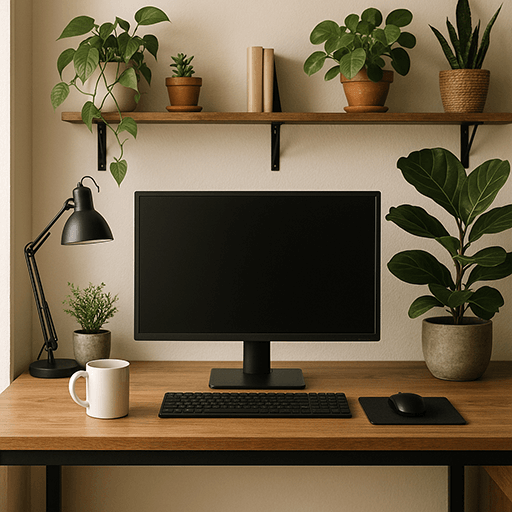

In [4]:
edit_input_path = "imgs/desk.png"
edit_input_img = open(edit_input_path, "rb")
display(IPImage(edit_input_path))

### アイテム編集

In [5]:
edit_prompt = "Make the mug olive green"
edit_result = edit_img(edit_input_img, edit_prompt)

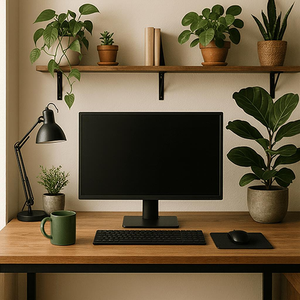

In [42]:
# Display result
edit_resized_result = resize_img(edit_result, 300)
display(edit_resized_result)

### アイテムを削除

In [7]:
remove_prompt = "Remove the mug from the desk"
remove_result = edit_img(edit_input_img, remove_prompt)

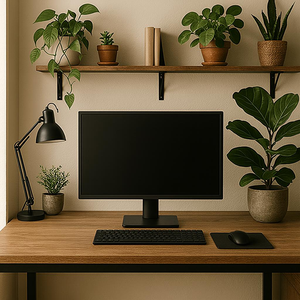

In [43]:
# Display result
remove_resized_result = resize_img(remove_result, 300)
display(remove_resized_result)

### アイテムの追加

In [9]:
add_prompt = "Add a post-it note saying 'Be right back!' to the monitor"
add_result = edit_img(edit_input_img, add_prompt)

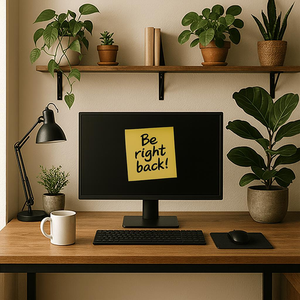

In [44]:
# Display result
add_resized_result = resize_img(add_result, 300)
display(add_resized_result)

## 顔の保持


高い入力忠実度を使用する場合、標準モードよりもはるかに正確に顔が保持されます。編集を通じて人物を認識可能な状態に保つ必要がある場合に使用してください。

使用例：
- **画像編集：** 顔の特徴を保持しながら写真を編集する。
- **パーソナライゼーション：** 異なる背景やスタイルでも元の人物に似たアバターを作成する。
- **写真の合成：** 複数の写真から顔を組み合わせて1つの画像にする。

**注意：** 現在、すべての入力画像は高い忠実度で保持されますが、最初に提供した画像のみがテクスチャの豊かさで特別に保持されます。異なる写真から複数の顔を扱う場合は、リクエストを送信する前に必要なすべての顔を1つの合成画像に組み合わせることを試してください（以下の例を参照）。

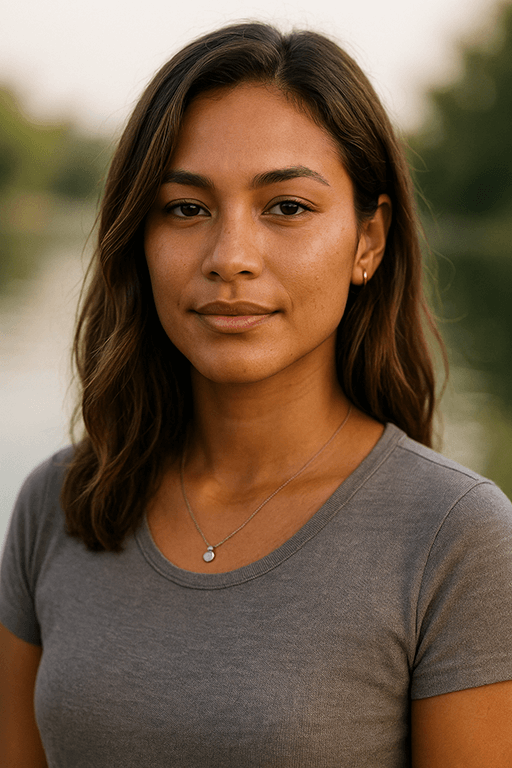

In [11]:
face_input_path = "imgs/woman_portrait.png"
face_input_img = open(face_input_path, "rb")
display(IPImage(face_input_path))

### 画像編集

In [12]:
edit_face_prompt = "Add soft neon purple and lime green lighting and glowing backlighting."
edit_face_result = edit_img(face_input_img, edit_face_prompt)

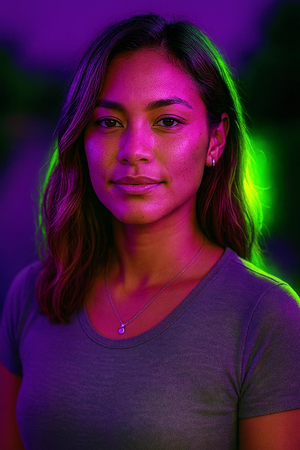

In [45]:
# Display result
edit_face_resized_result = resize_img(edit_face_result, 300)
display(edit_face_resized_result)

### アバター

In [14]:
avatar_prompt = "Generate an avatar of this person in digital art style, with vivid splash of colors."
avatar_result = edit_img(face_input_img, avatar_prompt)

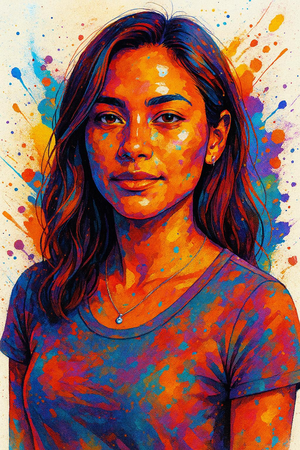

In [46]:
# Display result
avatar_resized_result = resize_img(avatar_result, 300)
display(avatar_resized_result)

### 顔のある複数の写真を組み合わせる

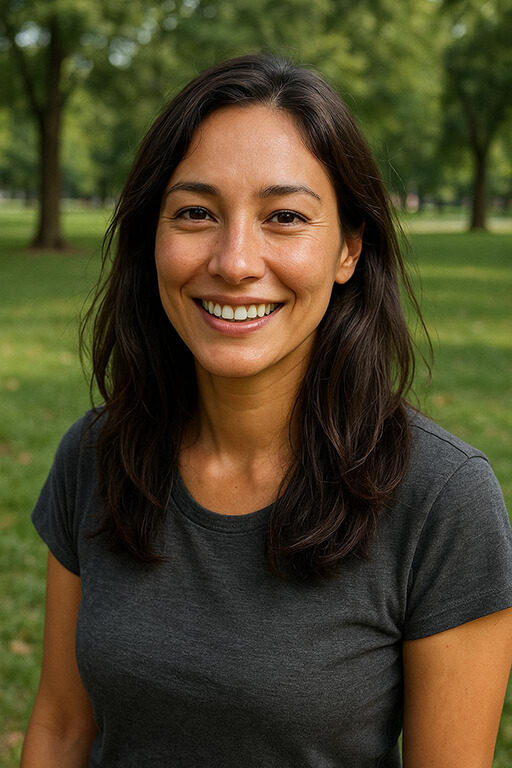

In [16]:
second_woman_input_path = "imgs/woman_smiling.jpg"
second_woman_input_img = open(second_woman_input_path, "rb")
display(IPImage(second_woman_input_path))

In [17]:
def combine_imgs(left_path, right_path, bg_color=(255, 255, 255)):
    
    left_img = Image.open(open(left_path, "rb"))
    right_img = Image.open(open(right_path, "rb"))
    
    # Ensure RGBA for safe pasting (handles transparency)
    left = left_img.convert("RGBA")
    right = right_img.convert("RGBA")

    # Resize right to match left height
    target_h = left.height
    scale = target_h / float(right.height)
    target_w = int(round(right.width * scale))
    right = right.resize((target_w, target_h), Image.LANCZOS)

    # New canvas
    total_w = left.width + right.width
    canvas = Image.new("RGBA", (total_w, target_h), bg_color + (255,))

    # Paste
    canvas.paste(left, (0, 0), left)
    canvas.paste(right, (left.width, 0), right)

    return canvas

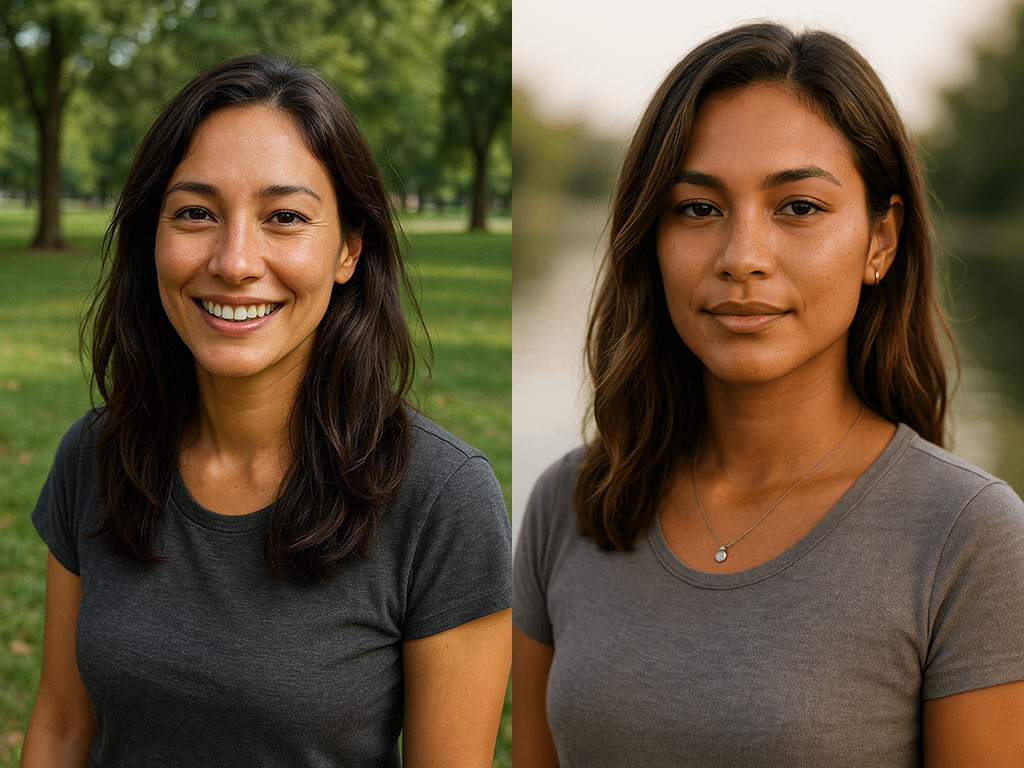

In [54]:
combined_img = combine_imgs(second_woman_input_path, face_input_path)
display(combined_img)

In [20]:
import io

# utility function to convert to bytes
def pil_to_bytes(img, fmt="PNG"):
    buf = io.BytesIO()
    img.save(buf, format=fmt)
    buf.seek(0)
    return buf

combined_img_bytes = pil_to_bytes(combined_img)

In [21]:
combined_prompt = "Put these two women in the same picture, holding shoulders, as if part of the same photo."
combined_result = edit_img(("combined.png", combined_img_bytes, "image/png"), combined_prompt)

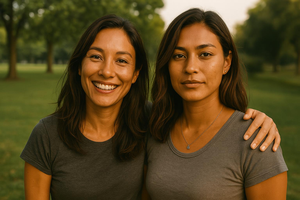

In [47]:
# Display result
combined_resized_result = resize_img(combined_result, 300)
display(combined_resized_result)

## ブランドの一貫性

生成された画像でブランドアイデンティティを維持することが重要な場合があります。高い入力忠実度により、ロゴやその他の独自のデザイン要素が元のアセットに忠実に保たれます。

使用例：
- **マーケティングアセット：** ブランドロゴを歪ませることなく含むバナーやソーシャル投稿を生成する。
- **モックアップ：** 意図しない変更を加えることなく、ロゴやその他のブランドアセットをテンプレートやライフスタイルシーンに配置する。
- **商品写真：** 商品の詳細を鮮明に保ちながら、異なるキャンペーン用に商品の背景を変更する。

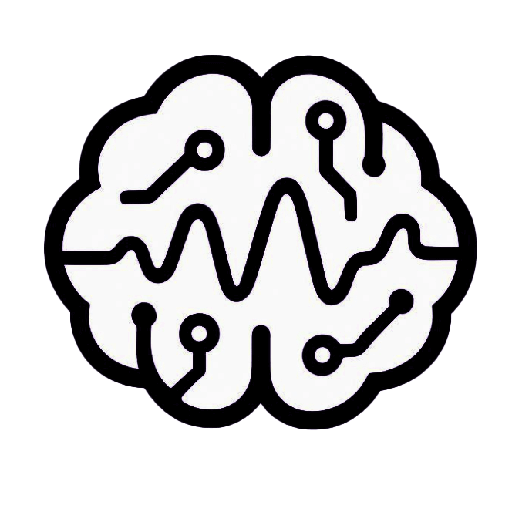

In [23]:
logo_input_path = "imgs/logo.png"
logo_input_img = open(logo_input_path, "rb")
display(IPImage(logo_input_path))

### マーケティング資産

In [24]:
marketing_prompt = "Generate a beautiful, modern hero banner featuring this logo in the center. It should look futuristic, with blue & violet hues."
marketing_result = edit_img(logo_input_img, marketing_prompt)

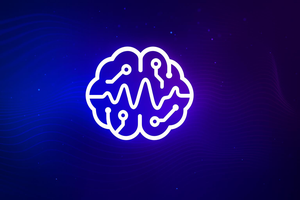

In [48]:
# Display result
marketing_resized_result = resize_img(marketing_result, 300)
display(marketing_resized_result)

### モックアップ

In [26]:
mockup_prompt = "Generate a highly realistic picture of a hand holding a tilted iphone, with an app on the screen that showcases this logo in the center with a loading animation below"
mockup_result = edit_img(logo_input_img, mockup_prompt)

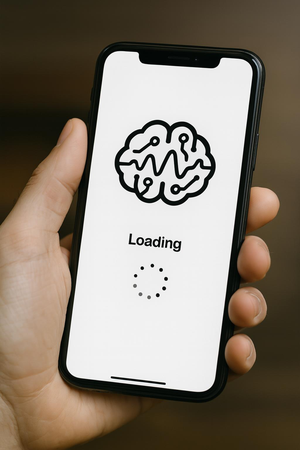

In [49]:
# Display result
mockup_resized_result = resize_img(mockup_result, 300)
display(mockup_resized_result)

### 商品撮影

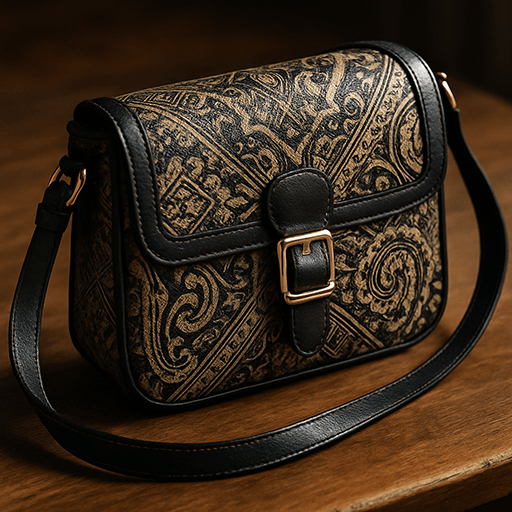

In [28]:
bag_input_path = "imgs/bag.png"
bag_input_img = open(bag_input_path, "rb")
display(IPImage(bag_input_path))

In [29]:
product_prompt = "Generate a beautiful ad with this bag in the center, on top of a dark background with a glowing halo emanating from the center, behind the bag."
product_result = edit_img(bag_input_img, product_prompt)

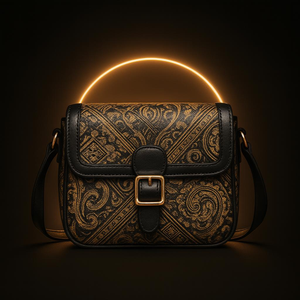

In [50]:
# Display result
product_resized_result = resize_img(product_result, 300)
display(product_resized_result)

## ファッション・商品レタッチ

Eコマースやファッション分野では、リアリズムを損なうことなく衣装や商品の詳細を編集することがよく求められます。高い入力忠実度により、生地のテクスチャ、パターン、ロゴの一貫性が保たれます。

使用例：
- **衣装のバリエーション:** モデル写真の衣服の色やスタイルを変更する。
- **アクセサリーの追加:** モデルのポーズや顔を変えることなく、ジュエリー、帽子、その他のアクセサリーを写真に追加する。
- **商品抽出:** 詳細を保ったまま、同じ商品や衣装を新しい設定で表示する。

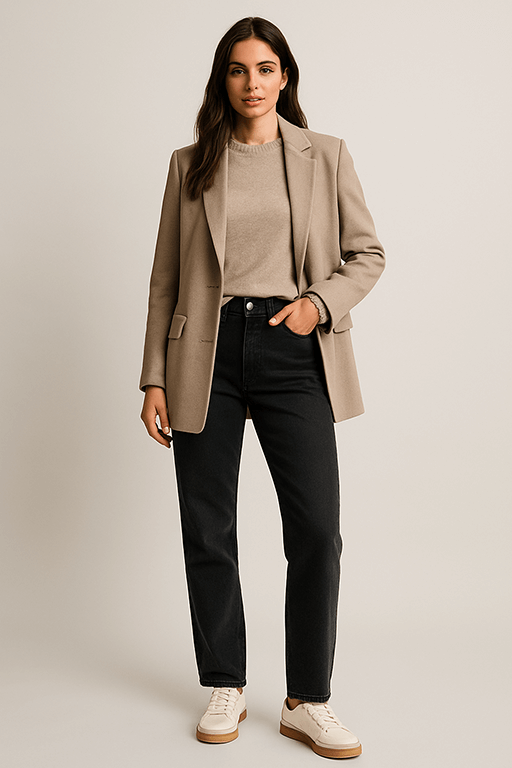

In [31]:
model_input_path = "imgs/model.png"
model_input_img = open(model_input_path, "rb")
display(IPImage(model_input_path))

### 服装のバリエーション

In [32]:
variation_prompt = "Edit this picture so that the model wears a blue tank top instead of the coat and sweater."
variation_result = edit_img(model_input_img, variation_prompt)

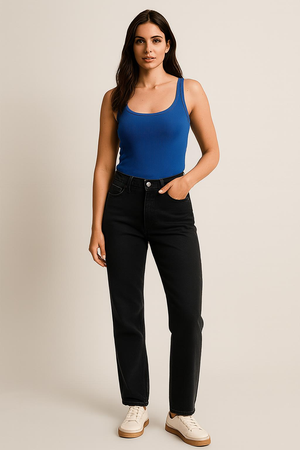

In [51]:
# Display result
variation_resized_result = resize_img(variation_result, 300)
display(variation_resized_result)

### アクセサリーの追加

この例では、2つの入力画像を組み合わせます。顔を含む画像は最初の入力として提供する必要があります。最初の画像からより多くの詳細が保持されるためです。

In [34]:
input_imgs = [('model.png',
                 open('imgs/model.png', 'rb'),
                 'image/png'),
    ('bag.png', open('imgs/bag.png', 'rb'),'image/png'),
]

In [35]:
accessory_prompt = "Add the crossbody bag to the outfit."
accessory_result = edit_img(input_imgs, accessory_prompt)

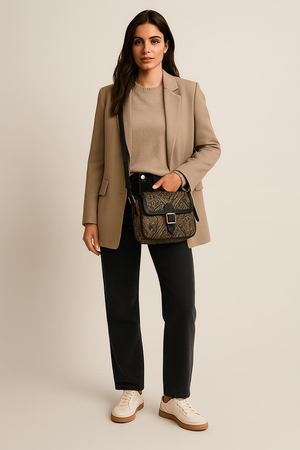

In [52]:
# Display result
accessory_resized_result = resize_img(accessory_result, 300)
display(accessory_resized_result)

### 商品抽出

In [37]:
extraction_prompt = "Generate a picture of this exact same jacket on a white background"
extraction_result = edit_img(model_input_img, extraction_prompt)

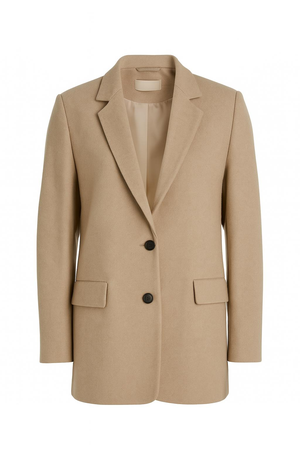

In [53]:
# Display result
extraction_resized_result = resize_img(extraction_result, 300)
display(extraction_resized_result)

## まとめ

このガイドでは、入力画像から重要な視覚的詳細をより良く保持するために、高入力忠実度を有効にする方法について説明しました。

上記の使用例を参考にして、あなた自身の画像でこのパラメータを試し、高入力忠実度が最も大きな違いを生む場面を確認してみてください。

高入力忠実度はデフォルトよりも多くの画像入力トークンを消費することを覚えておいてください。また、すべての入力画像が高入力忠実度で処理されますが、リストの最初の画像が最も細かい詳細と豊かなテクスチャを保持し、これは特に顔において重要です。

楽しく開発してください！